## Setup

In [1]:
import sys
from _path import workdir
sys.path.append(workdir)
print(sys.path)

['c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\python312.zip', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\DLLs', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys', '', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages\\win32', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\vince\\AppData\\Local\\anaconda3\\envs\\phys\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\vince\\OneDrive - The Chinese University of Hong Kong\\python projects\\py binary orbit\\paper_QPE2005\\..']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from scipy.optimize import root_scalar

from src.util.constants import G, msun, c
from src.orbit.empirical.WDBH_EMRI import rWD, rtide, wf, olapf
from src.orbit.mapping.single_mode.WD_MBH import s_map_WDBH_MT_expo, s_map_GW
from src.orbit.mapping.single_mode.WD_MBH import s_dq
from src.orbit.osculating.orb_avg_formula import de_2_5pn, da_2_5pn

### Initial parameters

In [3]:
mWD = 0.5*msun
mBH = 1.e5*msun
Torb = 9.*3600
a0 = (G*(mBH+mWD)*(Torb/2/np.pi)**2)**(1./3)
rt = rtide(mWD,mBH)

m1, r1 = mWD, rWD(mWD)
m2, r2 = mBH, 2*G*mBH/c**2

In [4]:
w_list1, olap_list1, ell_list1, m_list1 = [wf(mWD)], [olapf(mWD,0.5)], [2], [2]
w_list2, olap_list2, ell_list2, m_list2 = [], [], [], []

q10 = np.zeros(len(w_list1)*len(ell_list1)*len(m_list1))
q20 = np.zeros(len(w_list2)*len(ell_list2)*len(m_list2))

In [5]:
rp_list = np.linspace(3.5,4.5,350)*rt

In [6]:
sigma = 1.e-4
mu1 = 1.
ga = 1.

In [7]:
def max_n_GW(m1,m2,r1,wa,olap,rp,a0,ef):
    dq = s_dq(m1,m2,r1,wa,olap,rp)
    e0 = 1 - rp/a0
    P0K = 2*np.pi*np.sqrt(a0**3/G/(m1+m2))
    nf = int((ef-e0)/de_2_5pn(m1,m2,a0,e0)/P0K)
    return nf

In [8]:
def find_rp_break(a,m1,m2,w,olap):
    def _func(rp):
        e = 1 - rp/a
        P0K = 2*np.pi*np.sqrt(a**3/G/(m1+m2))
        n_cir = -0.1/de_2_5pn(m1,m2,a,e)/P0K
        return 0.1/n_cir/np.abs(s_dq(m1,m2,r1,w,olap,rp))**2 - 1.
    return root_scalar(_func, x0= 3.*rt).root

In [9]:
rp_break = find_rp_break(a0, m1,m2,w_list1[0],olap_list1[0])
ntot_break = max_n_GW(m1,m2,r1,w_list1[0],olap_list1[0],rp_break,a0,ef=0.9)

In [10]:
print(ntot_break)
print(1e4*Torb/31536000)

-21472332
10.273972602739725


In [11]:
f_resolution = 1./4/31536000
P_resolution = f_resolution*Torb**2

## Mapping

In [12]:
dP_full = np.empty_like(rp_list)
dP_gw_DT = np.empty_like(rp_list)
dP_gw = np.empty_like(rp_list)
for irp, rp in enumerate(rp_list):
    ncir = max_n_GW(m1,m2,r1,w_list1[0],olap_list1[0],rp,a0,ef=0.9)
    ntot = ncir
    # ntot = ntot_break
    qn, an, en, m1n, m2n = s_map_WDBH_MT_expo(m1,m2,w_list1[0],olap_list1[0],q10[0],a0,rp,sigma,ga,mu1,ntot, alpha = 1., q_break= 1.e-3, m1_min = 0.1, flag_vary_rp = True)
    qn_gw_DT, an_gw_DT, en_gw_DT = s_map_GW(m1,m2,r1,w_list1[0],olap_list1[0],q10[0],a0,rp,ntot, flag_vary_rp = True, flag_tidal_BR = True)
    qn_gw, an_gw, en_gw = s_map_GW(m1,m2,r1,w_list1[0],olap_list1[0],q10[0],a0,rp,ntot, flag_vary_rp = True, flag_tidal_BR = False)
    
    dP_full[irp] = 2*np.pi*np.max(np.abs((np.sqrt(an**3/G/(m1n+m2n))-np.sqrt(an[0]**3/G/(m1n[0]+m2n[0])))))
    dP_gw_DT[irp] = 2*np.pi*np.max(np.abs((np.sqrt(an_gw_DT**3/G/(m1+m2))-np.sqrt(an_gw_DT[0]**3/G/(m1+m2)))))
    dP_gw[irp] = 2*np.pi*np.max(np.abs((np.sqrt(an_gw**3/G/(m1+m2))-np.sqrt(an_gw[0]**3/G/(m1+m2)))))

### Plots

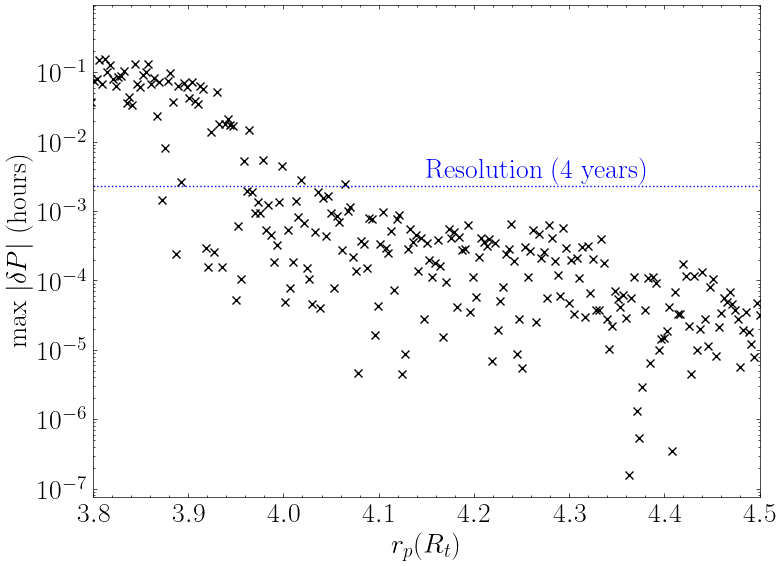

In [14]:
plt.figure(figsize=(8.6,6.4), dpi= 100)
plt.style.use('science')
# plt.plot(rp_list/rt,np.abs(dP_full-dP_gw)/3600., linestyle = '', marker = '+', color='black', label=r'$\sigma_1 = 10^{-4}$')
# plt.plot(rp_list/rt,np.abs(dP_gw_DT-dP_gw)/3600., linestyle = '', marker = 'x', color='red', label='Dynamical tide only')
plt.plot(rp_list/rt,np.abs(dP_gw_DT-dP_gw)/3600., linestyle = '', marker = 'x', color='black')
plt.axhline(P_resolution/3600., color = 'blue', linestyle = 'dotted')
# plt.axvline(4.1, color = 'red', linestyle = 'dotted')
plt.xlabel(r'$r_p (R_t)$',fontsize=20)
plt.ylabel(r'max $|\delta P|$ (hours)',fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([3.8,4.5])
plt.yscale('log')
# plt.legend(frameon = True, fontsize = 20)

plt.text(4.15, 3.e-3, r'Resolution (4 years)', color = 'blue', fontsize = 20)

plt.savefig("max_period_shift.pdf", format="pdf")
plt.show()
plt.close()